In [32]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 14.9 MB/s eta 0:00:00


In [1]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import re
import nltk
from nltk.corpus import stopwords
from langdetect import detect
from summa.summarizer import summarize as summa_summarizer
from nltk import sent_tokenize

# nltk.download('punkt')
# nltk.download('stopwords')

/data/elo/.conda/envs/vifree-txt-3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
try:
    with open('/data/elo/khanglg/FreeTxt-Flask/vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
        vi_stopwords = [line.strip() for line in f if line.strip()]
    print(f"Successfully loaded {len(vi_stopwords)} Vietnamese stopwords.")
except FileNotFoundError:
    print("Vietnamese stopwords file not found. Please ensure '/data/vietnamese_stopwords.txt' exists.")
    vi_stopwords = []

# Define punctuation
PUNCS = '''!→()-[]{};:'"\,<>?@#$%^&*_~'''

# Combine with English stopwords for broader demo if needed, or keep separate
# For this demo, we'll primarily focus on Vietnamese, but it's good to have access to English ones too.
try:
    en_stopwords = list(stopwords.words('english'))
except LookupError:
    print("NLTK English stopwords not found. Downloading...")
    nltk.download('stopwords')
    en_stopwords = list(stopwords.words('english'))

# STOPWORDS set will be dynamically chosen based on language in preprocess_text
STOPWORDS_DICT = {
    'en': set(en_stopwords),
    'vi': set(vi_stopwords)
}

Successfully loaded 1942 Vietnamese stopwords.


In [3]:
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Cell 2: Load Vietnamese Stopwords
try:
    with open('/data/elo/khanglg/FreeTxt-Flask/vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
        vi_stopwords = [line.strip() for line in f if line.strip()]
    print(f"Successfully loaded {len(vi_stopwords)} Vietnamese stopwords.")
except FileNotFoundError:
    print("Vietnamese stopwords file not found. Please check the path.")
    vi_stopwords = []

# Define punctuation
PUNCS = '''!→()-[]{};:'"\,<>?@#$%^&*_~'''

# Cell 3: Device Configuration
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Cell 4: Text Preprocessing Function
def preprocess_text(text, language='vi'):
    """
    Preprocesses text for sentiment analysis:
    - Converts input to string to handle potential NaNs or other types
    - Removes URLs, mentions, hashtags
    - Removes punctuation
    - Converts to lowercase
    - Removes stopwords
    """
    text = str(text) # Convert text to string to prevent TypeError
    text = re.sub(r"http\\S+|@\\S+|#\\S+", "", text)
    text = re.sub(f"[{re.escape(''.join(PUNCS))}]", "", text.lower())
    text = " ".join(word for word in text.split() if word not in vi_stopwords)
    return text



Successfully loaded 1942 Vietnamese stopwords.
Using device: cuda:1


In [39]:
from underthesea import word_tokenize
from underthesea import text_normalize

def preprocess_text_underthesea(text):
    text = str(text)
    segmented_text = word_tokenize(text, format="text")
    processed_text = segmented_text
    processed_text = re.sub(r"http\\S+|@\\S+|#\\S+", "", processed_text)
    processed_text = re.sub(f"[{re.escape(''.join(PUNCS))}]", "", processed_text.lower())
    words = processed_text.split()
    words = [word for word in words if word not in vi_stopwords and word.strip()]
    processed_text = " ".join(words)
    processed_text = re.sub(r'\s+', ' ', processed_text).strip()
    return processed_text

In [37]:
import re
import unicodedata
import emoji

def normalize_unicode(text):
    return unicodedata.normalize('NFC', text)

def preprocess_text_underthesea(text):
    text = str(text)
    text = normalize_unicode(text) # Use the script-specific renamed function
    text = emoji.demojize(text)

    text = re.sub(r"http\S+|@\S+|#\S+", "", text)
    
    # For the script, we assume it's always Vietnamese as it's specialized.
    # If it needs to be multilingual, you'd pass a language flag.
    tokens = word_tokenize(text, format="list")

    processed_tokens = []
    for t in tokens:
        t_lower = t.lower()
        is_stopword = (t_lower in vi_stopwords)
        
        if not is_stopword and re.search(r'\w', t_lower):
            processed_tokens.append(t_lower)
            
    processed_text = " ".join(processed_tokens)
    processed_text = re.sub(f"[{re.escape(''.join(PUNCS))}]", "", processed_text)
    processed_text = re.sub(r'\s+', ' ', processed_text).strip()
    return processed_text

In [45]:
import re
import string
import unicodedata
from underthesea import word_tokenize

# Emoji pattern
emoji_pattern = re.compile("["                                
    u"\U0001F600-\U0001F64F"  # Emoticons
    u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # Transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # Flags
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u200d"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\u3030"
    u"\ufe0f"
    "]+", flags=re.UNICODE)

def text_normalize(text):
    return unicodedata.normalize('NFC', text)

def preprocess_text_underthesea(text, remove_stopwords=True):
    """
    Advanced Vietnamese text cleaning and tokenization.
    """
    text = str(text).lower()
    text = re.sub(emoji_pattern, " ", text)  # Remove emojis
    text = re.sub(r"http\S+|@\S+|#\S+", "", text)
    text = re.sub(r'([a-zA-ZÀÁẠẢÃÂẦẤẬẨẪĂẰẮẶẲẴÈÉẸẺẼÊỀẾỆỂỄÌÍỊỈĨÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠÙÚỤỦŨƯỪỨỰỬỮỲÝỴỶỸĐđ]+?)\1+', r'\1', text)  # Reduce repeated characters
    
    # Normalize punctuation spacing
    text = re.sub(r"(\w)\s*([{}])\s*(\w)".format(re.escape(string.punctuation)), r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([{}])".format(re.escape(string.punctuation)), r"\1 \2", text)
    text = re.sub(r"([{p}])([{p}])+".format(p=re.escape(string.punctuation)), r"\1", text)

    # Remove leading/trailing punctuation or space
    text = text.strip()
    while text and text[-1] in string.punctuation + string.whitespace:
        text = text[:-1]
    while text and text[0] in string.punctuation + string.whitespace:
        text = text[1:]

    # Remove all punctuation except Vietnamese letters
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r"\s+", " ", text)

    # Normalize unicode (important for Vietnamese tone marks)
    text = text_normalize(text)

    # Tokenize
    tokens = word_tokenize(text, format="list")

    # Optional: stopword filtering
    if remove_stopwords:
        tokens = [w for w in tokens if w not in vi_stopwords and w.strip()]

    return " ".join(tokens)


In [46]:
test_sentences = [
    "Tuyệtttttttttttttttttttttttttttttttttttttttttttttttttttttt vờiiiiiiiiii 😍😍😍😍!!!",
    "@user1 Ko bh quay lại đâu!!!! Dở ẹc luôn :( #thất_vọng http://sadlink.vn",
    "huhu hú hú hú hú hú hú hú hú 😭😭😭😭😭😭😭😭😭😭",
    "Tệ. Rất tệ. QUÁ TỆ!!! Như *cái* gì đó không thể chấp nhận 😡😡😡",
    "dịch vụ rất rất rất rất rất rất rất rất rất rất tệ",
    "Không đáng đồng tiền bát gạo! Một sản phẩm quá TỆ trong tầm giá.",
    "...thật tuyệt...tuyệtttttt...quá tuyệtttt...",
    "Mọi thứ đều \"ổn\"... nhưng \"KHÔNG THỰC SỰ ỔN\"",
    "sản phẩm này đẹp quá trời luôn đó mngg ơiiiiiiiii",
    "#Yêu#Thích@spNày! Dùng thử xong kh muốn bỏ luôn. 💕💞",
    "Tôi không nghĩ là tôi sẽ mua lần nữa đâu nhaaaa :))))",
    "Best buy ever, rất good. I like it so so soooo much! :3"
]

for i, sentence in enumerate(test_sentences, 1):
    print(f"\n--- Sample {i} ---")
    print("Original:", sentence)
    print("Processed:", preprocess_text_underthesea(sentence))


--- Sample 1 ---
Original: Tuyệtttttttttttttttttttttttttttttttttttttttttttttttttttttt vờiiiiiiiiii 😍😍😍😍!!!
Processed: tuyệt vời

--- Sample 2 ---
Original: @user1 Ko bh quay lại đâu!!!! Dở ẹc luôn :( #thất_vọng http://sadlink.vn
Processed: user1 ko bh dở ẹc thất vọng htp sadlink vn

--- Sample 3 ---
Original: huhu hú hú hú hú hú hú hú hú 😭😭😭😭😭😭😭😭😭😭
Processed: hu hú hú hú hú hú hú hú hú

--- Sample 4 ---
Original: Tệ. Rất tệ. QUÁ TỆ!!! Như *cái* gì đó không thể chấp nhận 😡😡😡
Processed: tệ tệ tệ chấp nhận

--- Sample 5 ---
Original: dịch vụ rất rất rất rất rất rất rất rất rất rất tệ
Processed: dịch vụ tệ

--- Sample 6 ---
Original: Không đáng đồng tiền bát gạo! Một sản phẩm quá TỆ trong tầm giá.
Processed: đồng tiền bát gạo sản phẩm tệ tầm giá

--- Sample 7 ---
Original: ...thật tuyệt...tuyệtttttt...quá tuyệtttt...
Processed: tuyệt tuyệt tuyệt

--- Sample 8 ---
Original: Mọi thứ đều "ổn"... nhưng "KHÔNG THỰC SỰ ỔN"
Processed: ổn ổn

--- Sample 9 ---
Original: sản phẩm này đẹp quá trời l

In [43]:
# Sample texts to compare preprocessing
sample_texts = [
    "Tôi RẤT THÍCH sản phẩm này! Nó thật tuyệt vời. #TuyetVoi http://example.com @user",
    "Dịch vụ khách hàng ở đây rất tệ, không bao giờ quay lại.",
    "Sản phẩm tạm ổn, không có gì đặc biệt.",
    "Học máy là một lĩnh vực thú vị của trí tuệ nhân tạo, đặc biệt là xử lý ngôn ngữ tự nhiên.",
    "Cuốn sách này viết rất hay và dễ hiểu."
]

print("Comparing preprocessing functions:\n")

for i, text in enumerate(sample_texts):
    print(f"--- Sample {i+1} ---")
    print(f"Original:           '{text}'")
    
    processed_standard = preprocess_text(text)
    print(f"preprocess_text:    '{processed_standard}'")
    
    processed_underthesea = preprocess_text_underthesea(text)
    print(f"preprocess_underthesea: '{processed_underthesea}'")
    print("-" * 20 + "\n")

# Example with a more complex sentence for underthesea
complex_text = "Trường Đại học Khoa học Tự nhiên Thành phố Hồ Chí Minh là một trong những trường hàng đầu."
print(f"--- Complex Sample ---")
print(f"Original:           '{complex_text}'")
print(f"Raw underthesea tokenize: '{word_tokenize(complex_text, format='text')}'")
processed_standard_complex = preprocess_text(complex_text)
print(f"preprocess_text:    '{processed_standard_complex}'")
processed_underthesea_complex = preprocess_text_underthesea(complex_text)
print(f"preprocess_underthesea: '{processed_underthesea_complex}'")
print("-" * 20 + "\n")


Comparing preprocessing functions:

--- Sample 1 ---
Original:           'Tôi RẤT THÍCH sản phẩm này! Nó thật tuyệt vời. #TuyetVoi http://example.com @user'
preprocess_text:    'sản phẩm tuyệt vời. tuyetvoi http//example.com user'
preprocess_underthesea: 'sản phẩm tuyệt vời'
--------------------

--- Sample 2 ---
Original:           'Dịch vụ khách hàng ở đây rất tệ, không bao giờ quay lại.'
preprocess_text:    'dịch vụ hàng tệ bao lại.'
preprocess_underthesea: 'dịch vụ khách hàng tệ'
--------------------

--- Sample 3 ---
Original:           'Sản phẩm tạm ổn, không có gì đặc biệt.'
preprocess_text:    'sản phẩm tạm ổn đặc biệt.'
preprocess_underthesea: 'sản phẩm tạm ổn'
--------------------

--- Sample 4 ---
Original:           'Học máy là một lĩnh vực thú vị của trí tuệ nhân tạo, đặc biệt là xử lý ngôn ngữ tự nhiên.'
preprocess_text:    'học máy lĩnh vực thú vị trí tuệ nhân đặc biệt xử lý ngôn ngữ nhiên.'
preprocess_underthesea: 'học máy lĩnh vực thú vị trí tuệ nhân tạo ngôn ngữ tự nh

In [21]:
# Sample texts to compare preprocessing
sample_texts = [
    "Tôi RẤT THÍCH sản phẩm này! Nó thật tuyệt vời. #TuyetVoi http://example.com @user",
    "Dịch vụ khách hàng ở đây rất tệ, không bao giờ quay lại.",
    "Sản phẩm tạm ổn, không có gì đặc biệt.",
    "Học máy là một lĩnh vực thú vị của trí tuệ nhân tạo, đặc biệt là xử lý ngôn ngữ tự nhiên.",
    "Cuốn sách này viết rất hay và dễ hiểu."
]

print("Comparing preprocessing functions:\n")

for i, text in enumerate(sample_texts):
    print(f"--- Sample {i+1} ---")
    print(f"Original:           '{text}'")
    
    processed_standard = preprocess_text(text)
    print(f"preprocess_text:    '{processed_standard}'")
    
    processed_underthesea = preprocess_text_underthesea(text)
    print(f"preprocess_underthesea: '{processed_underthesea}'")
    print("-" * 20 + "\n")

# Example with a more complex sentence for underthesea
complex_text = "Trường Đại học Khoa học Tự nhiên Thành phố Hồ Chí Minh là một trong những trường hàng đầu."
print(f"--- Complex Sample ---")
print(f"Original:           '{complex_text}'")
print(f"Raw underthesea tokenize: '{word_tokenize(complex_text, format='text')}'")
processed_standard_complex = preprocess_text(complex_text)
print(f"preprocess_text:    '{processed_standard_complex}'")
processed_underthesea_complex = preprocess_text_underthesea(complex_text)
print(f"preprocess_underthesea: '{processed_underthesea_complex}'")
print("-" * 20 + "\n")


Comparing preprocessing functions:

--- Sample 1 ---
Original:           'Tôi RẤT THÍCH sản phẩm này! Nó thật tuyệt vời. #TuyetVoi http://example.com @user'
preprocess_text:    'sản phẩm tuyệt vời. tuyetvoi http//example.com user'
preprocess_underthesea: 'sảnphẩm tuyệtvời . tuyetvoihttp//example.com user'
--------------------

--- Sample 2 ---
Original:           'Dịch vụ khách hàng ở đây rất tệ, không bao giờ quay lại.'
preprocess_text:    'dịch vụ hàng tệ bao lại.'
preprocess_underthesea: 'dịchvụ kháchhàng tệ baogiờ .'
--------------------

--- Sample 3 ---
Original:           'Sản phẩm tạm ổn, không có gì đặc biệt.'
preprocess_text:    'sản phẩm tạm ổn đặc biệt.'
preprocess_underthesea: 'sảnphẩm tạm ổn đặcbiệt .'
--------------------

--- Sample 4 ---
Original:           'Học máy là một lĩnh vực thú vị của trí tuệ nhân tạo, đặc biệt là xử lý ngôn ngữ tự nhiên.'
preprocess_text:    'học máy lĩnh vực thú vị trí tuệ nhân đặc biệt xử lý ngôn ngữ nhiên.'
preprocess_underthesea: 'học máy 

In [5]:
import torch

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda:7


In [5]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

model.to(device)



BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [6]:
def analyse_sentiment_notebook(input_text, language_code='vi', num_classes=3, max_seq_len=512):
    """
    Analyzes the sentiment of the input text for the notebook.
    Args:
        input_text (str or list): A single text string or a list of text strings (reviews).
        language_code (str): 'vi' for Vietnamese, 'en' for English.
        num_classes (int): 3 or 5 for the number of sentiment classes.
        max_seq_len (int): Maximum sequence length for the tokenizer.
    Returns:
        tuple: (list_of_sentiments, sentiment_counts_dict)
               list_of_sentiments contains tuples of (original_review, sentiment_label, sentiment_score)
    """
    global model, tokenizer, device # Ensure we're using the globally defined model, tokenizer, and device

    if isinstance(input_text, str):
        reviews = [input_text] # If single text, make it a list
    elif isinstance(input_text, list):
        reviews = input_text
    else:
        raise ValueError("input_text must be a string or a list of strings.")

    sentiment_labels_5_class = {
        'vi': ['Rất tiêu cực', 'Tiêu cực', 'Trung tính', 'Tích cực', 'Rất tích cực'],
        'en': ['Very negative', 'Negative', 'Neutral', 'Positive', 'Very positive']
    }
    sentiment_labels_3_class = {
        'vi': ['Tiêu cực', 'Trung tính', 'Tích cực'],
        'en': ['Negative', 'Neutral', 'Positive']
    }

    if int(num_classes) == 3:
        current_sentiment_labels = sentiment_labels_3_class.get(language_code, sentiment_labels_3_class['en'])
    elif int(num_classes) == 5:
        current_sentiment_labels = sentiment_labels_5_class.get(language_code, sentiment_labels_5_class['en'])
    else:
        raise ValueError("num_classes must be 3 or 5.")
    
    output_labels_map = current_sentiment_labels # This was slightly redundant, simplifying
    sentiment_counts = {label: 0 for label in output_labels_map}
    processed_sentiments = []

    for review_text in reviews:
        original_review = review_text
        preprocessed_review = preprocess_text(review_text, language=language_code)

        if preprocessed_review.strip():
            tokens = tokenizer.encode(preprocessed_review, add_special_tokens=True, truncation=False)

            token_chunks = []
            if len(tokens) > max_seq_len:
                for i in range(0, len(tokens), max_seq_len):
                    chunk = tokens[i:i + max_seq_len]
                    token_chunks.append(chunk)
            else:
                token_chunks.append(tokens)

            chunk_scores_list = []
            for chunk in token_chunks:
                input_ids = torch.tensor([chunk]).to(device) # Move to device
                attention_mask = torch.tensor([[1] * len(chunk)]).to(device) # Move to device

                with torch.no_grad():
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                
                scores = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0] # Move scores to CPU for numpy
                chunk_scores_list.append(scores)
            
            avg_scores = np.mean(chunk_scores_list, axis=0)
            
            # If you want to inspect the scores for each of the 5 model output classes for the current review,
            # uncomment the following lines. This is useful for debugging or understanding model behavior.
            # Note: These are the raw scores from the 5-class model output, before any potential
            # mapping to a 3-class system (if num_classes=3 is chosen).
            #
            # print(f"--- Detailed scores for review (truncated): '{original_review[:70]}...' ---")
            # # Fetch the 5-class labels corresponding to the model's output neurons
            # model_output_labels = sentiment_labels_5_class.get(language_code, sentiment_labels_5_class['en'])
            # for i, score_value in enumerate(avg_scores):
            #     # avg_scores has 5 elements, corresponding to the 5 output classes of the model
            #     print(f"  Class '{model_output_labels[i]}': {score_value:.4f}")
            # print(f"  Predicted 5-class index (argmax): {avg_scores.argmax()}")
            # print(f"--- End detailed scores ---")
            
            five_class_sentiment_index = avg_scores.argmax()
            
            if int(num_classes) == 3:
                if five_class_sentiment_index < 2:
                    sentiment_label = output_labels_map[0]
                elif five_class_sentiment_index == 2:
                    sentiment_label = output_labels_map[1]
                else:
                    sentiment_label = output_labels_map[2]
                sentiment_score = float(format(avg_scores[five_class_sentiment_index], ".2f"))
            else: # num_classes == 5
                sentiment_label = output_labels_map[five_class_sentiment_index]
                sentiment_score = float(format(avg_scores[five_class_sentiment_index], ".2f"))

            processed_sentiments.append((original_review, sentiment_label, sentiment_score))
            if sentiment_label in sentiment_counts:
                 sentiment_counts[sentiment_label] += 1
            else:
                print(f"Warning: Sentiment label '{sentiment_label}' not in sentiment_counts initialization.")
                sentiment_counts[sentiment_label] = 1
        else:
            processed_sentiments.append((original_review, "N/A (empty after preprocessing)", 0.0))
    return processed_sentiments, sentiment_counts

print("Updated sentiment analysis function loaded (with .to(device) for inputs).")

Updated sentiment analysis function loaded (with .to(device) for inputs).


In [7]:
def run_summarizer_notebook(input_text, chosen_ratio=0.2, lang='vi'): # Default lang to 'vi'
    """
    Summarizes the input text using TextRank, with fallback.
    Args:
        input_text (str or iterable): Text to summarize.
        chosen_ratio (float): Proportion of sentences for summary. Min 0.1.
        lang (str): Language code (e.g., 'vi', 'en'). Summa summarizer has lang param but might not be fully effective for all.
                    NLTK's sent_tokenize is language-aware if models are downloaded.
    Returns:
        str: The summary or fallback message.
    """
    if not isinstance(input_text, str):
        input_text = ' '.join(map(str, input_text)) # Ensure it's a string
    
    # Ensure chosen_ratio is at least 0.1 or sensible default
    chosen_ratio = max(chosen_ratio, 0.1)

    # Use summa_summarizer, which has a language parameter (though its effectiveness for Vietnamese might vary)
    # It primarily uses TextRank which is somewhat language agnostic but sentence tokenization matters.
    try:
        # For Vietnamese, ensure NLTK's 'punkt' tokenizer is aware or use a Vi-specific sentence tokenizer if available
        # For now, relying on NLTK's default or previously downloaded 'punkt'
        summary = summa_summarizer(input_text, ratio=chosen_ratio, language='english' if lang != 'vi' else 'vietnamese') # Summa supports 'vietnamese'
    except Exception as e:
        print(f"Error during summarization: {e}")
        summary = ""
        
    if summary.strip():
        return summary
    else:
        # Fallback if summary is empty
        # Ensure sentence tokenization is appropriate for the language
        try:
            # NLTK's sent_tokenize can use language-specific models if 'punkt' is up-to-date.
            # For specific Vietnamese sentence tokenization, a library like 'underthesea' might be better in a full app.
            sentences = sent_tokenize(input_text) # nltk.sent_tokenize
        except Exception as e:
            print(f"Error tokenizing sentences for fallback: {e}")
            sentences = input_text.split('.') # Very basic fallback tokenizer

        if sentences and sentences[0].strip():
            # Return the first sentence if it's not empty
            if len(sentences) > 0 and sentences[0].strip():
                 return sentences[0].strip() + ('.' if not sentences[0].strip().endswith('.') else '')
            else:
                return "Không thể tóm tắt văn bản đầu vào. (Unable to summarize the input text - empty after sentence tokenization)."
        else:
            return "Không thể tóm tắt văn bản đầu vào. (Unable to summarize the input text - no sentences found)."

print("Summarization function loaded.")

Summarization function loaded.


In [8]:
## Testing the summarizer and sentiment analyser

# Example Vietnamese Text
example_texts_vi = [
    "Bộ phim này thực sự tuyệt vời! Diễn xuất và cốt truyện đều xuất sắc.", # Positive
    "Tôi không thích cuốn sách này lắm, nó khá nhàm chán và dễ đoán.", # Negative
    "Sản phẩm ở mức trung bình, không có gì đặc biệt nhưng cũng không tệ.", # Neutral
    "Dịch vụ khách hàng rất tệ, họ không giải quyết được vấn đề của tôi và rất thô lỗ.", # Very Negative
    "Đây là một trong những trải nghiệm ẩm thực tốt nhất mà tôi từng có. Mọi thứ đều hoàn hảo!", # Very Positive
    "Thời tiết hôm nay cũng bình thường, không nắng không mưa.", # Neutral
    "Chuyến đi thật kinh khủng, khách sạn bẩn và nhân viên thì thiếu chuyên nghiệp. Tôi sẽ không bao giờ quay lại đó nữa. Thật là một sự lãng phí tiền bạc." # Strongly negative
]

example_long_text_vi = """
Hà Nội, thủ đô của Việt Nam, là một thành phố cổ kính với hơn một nghìn năm lịch sử. 
Nơi đây nổi tiếng với kiến trúc Pháp thuộc, những hồ nước yên bình và một nền văn hóa ẩm thực đường phố phong phú. 
Du khách đến Hà Nội thường bị cuốn hút bởi sự pha trộn giữa nét cổ điển và hiện đại. 
Một trong những điểm đến không thể bỏ qua là Văn Miếu - Quốc Tử Giám, trường đại học đầu tiên của Việt Nam. 
Hồ Hoàn Kiếm, trái tim của thành phố, mang trong mình những truyền thuyết lịch sử và là nơi người dân địa phương tụ tập vui chơi. 
Ẩm thực Hà Nội cũng là một điểm nhấn đặc biệt, với các món ăn như phở, bún chả, và cà phê trứng đã trở thành biểu tượng. 
Tuy nhiên, thành phố cũng đối mặt với những thách thức như tắc nghẽn giao thông và ô nhiễm không khí. 
Chính quyền thành phố đang nỗ lực cải thiện cơ sở hạ tầng và nâng cao chất lượng cuộc sống cho người dân. 
Nhìn chung, Hà Nội vẫn là một điểm đến hấp dẫn với nhiều điều thú vị để khám phá.
"""

print("Example Vietnamese texts loaded.")

Example Vietnamese texts loaded.


In [9]:
print("--- Running 3-Class Sentiment Analysis (Vietnamese) ---")
sentiments_3_class, counts_3_class = analyse_sentiment_notebook(
    example_texts_vi, 
    language_code='vi', 
    num_classes=3
)

for review, label, score in sentiments_3_class:
    print(f"Review: {review}\nSentiment: {label} (Score: {score})\n---")
print("\nSentiment Counts (3-Class):")
for label, count in counts_3_class.items():
    print(f"{label}: {count}")

# How to modify:
# 1. Change example_texts_vi to your own list of Vietnamese strings.
# 2. To read from a CSV:
#    - You'd first load the CSV (e.g., using pandas: import pandas as pd; df = pd.read_csv('your_file.csv'))
#    - Then get the text column as a list: texts_from_csv = df['your_text_column_name'].tolist()
#    - Pass this list: analyse_sentiment_notebook(texts_from_csv, language_code='vi', num_classes=3)

--- Running 3-Class Sentiment Analysis (Vietnamese) ---
Review: Bộ phim này thực sự tuyệt vời! Diễn xuất và cốt truyện đều xuất sắc.
Sentiment: Tích cực (Score: 0.69)
---
Review: Tôi không thích cuốn sách này lắm, nó khá nhàm chán và dễ đoán.
Sentiment: Tích cực (Score: 0.37)
---
Review: Sản phẩm ở mức trung bình, không có gì đặc biệt nhưng cũng không tệ.
Sentiment: Trung tính (Score: 0.48)
---
Review: Dịch vụ khách hàng rất tệ, họ không giải quyết được vấn đề của tôi và rất thô lỗ.
Sentiment: Tích cực (Score: 0.35)
---
Review: Đây là một trong những trải nghiệm ẩm thực tốt nhất mà tôi từng có. Mọi thứ đều hoàn hảo!
Sentiment: Tích cực (Score: 0.48)
---
Review: Thời tiết hôm nay cũng bình thường, không nắng không mưa.
Sentiment: Trung tính (Score: 0.36)
---
Review: Chuyến đi thật kinh khủng, khách sạn bẩn và nhân viên thì thiếu chuyên nghiệp. Tôi sẽ không bao giờ quay lại đó nữa. Thật là một sự lãng phí tiền bạc.
Sentiment: Tiêu cực (Score: 0.59)
---

Sentiment Counts (3-Class):
Tiêu c

In [10]:
print("\n--- Running 5-Class Sentiment Analysis (Vietnamese) ---")
sentiments_5_class, counts_5_class = analyse_sentiment_notebook(
    example_texts_vi, 
    language_code='vi', 
    num_classes=5
)

for review, label, score in sentiments_5_class:
    print(f"Review: {review}\nSentiment: {label} (Score: {score})\n---")
print("\nSentiment Counts (5-Class):")
for label, count in counts_5_class.items():
    print(f"{label}: {count}")

# How to modify: Similar to 3-class, change example_texts_vi or load from a CSV.


--- Running 5-Class Sentiment Analysis (Vietnamese) ---
Review: Bộ phim này thực sự tuyệt vời! Diễn xuất và cốt truyện đều xuất sắc.
Sentiment: Rất tích cực (Score: 0.69)
---
Review: Tôi không thích cuốn sách này lắm, nó khá nhàm chán và dễ đoán.
Sentiment: Tích cực (Score: 0.37)
---
Review: Sản phẩm ở mức trung bình, không có gì đặc biệt nhưng cũng không tệ.
Sentiment: Trung tính (Score: 0.48)
---
Review: Dịch vụ khách hàng rất tệ, họ không giải quyết được vấn đề của tôi và rất thô lỗ.
Sentiment: Tích cực (Score: 0.35)
---
Review: Đây là một trong những trải nghiệm ẩm thực tốt nhất mà tôi từng có. Mọi thứ đều hoàn hảo!
Sentiment: Rất tích cực (Score: 0.48)
---
Review: Thời tiết hôm nay cũng bình thường, không nắng không mưa.
Sentiment: Trung tính (Score: 0.36)
---
Review: Chuyến đi thật kinh khủng, khách sạn bẩn và nhân viên thì thiếu chuyên nghiệp. Tôi sẽ không bao giờ quay lại đó nữa. Thật là một sự lãng phí tiền bạc.
Sentiment: Rất tiêu cực (Score: 0.59)
---

Sentiment Counts (5-C


--- Plotting 3-Class Sentiment Distribution (Vietnamese) ---


/tmp/ipykernel_92806/1408500683.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', num_labels)


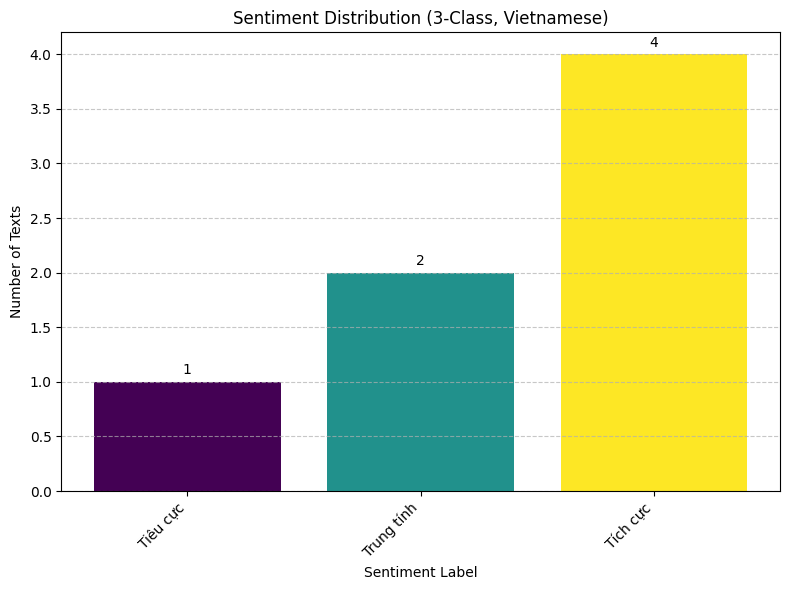



--- Running 5-Class Sentiment Analysis (Vietnamese) ---

Sentiment Analysis Results (5-Class):
Review: Bộ phim này thực sự tuyệt vời! Diễn xuất và cốt truyện đều xuất sắc....
Sentiment: Rất tích cực (Score: 0.69)
---
Review: Tôi không thích cuốn sách này lắm, nó khá nhàm chán và dễ đoán....
Sentiment: Tích cực (Score: 0.37)
---
Review: Sản phẩm ở mức trung bình, không có gì đặc biệt nhưng cũng không tệ....
Sentiment: Trung tính (Score: 0.48)
---
Review: Dịch vụ khách hàng rất tệ, họ không giải quyết được vấn đề của tôi và ...
Sentiment: Tích cực (Score: 0.35)
---
Review: Đây là một trong những trải nghiệm ẩm thực tốt nhất mà tôi từng có. Mọ...
Sentiment: Rất tích cực (Score: 0.48)
---
Review: Thời tiết hôm nay cũng bình thường, không nắng không mưa....
Sentiment: Trung tính (Score: 0.36)
---
Review: Chuyến đi thật kinh khủng, khách sạn bẩn và nhân viên thì thiếu chuyên...
Sentiment: Rất tiêu cực (Score: 0.59)
---

Sentiment Counts (5-Class):
Rất tiêu cực: 1
Tiêu cực: 0
Trung tính: 2


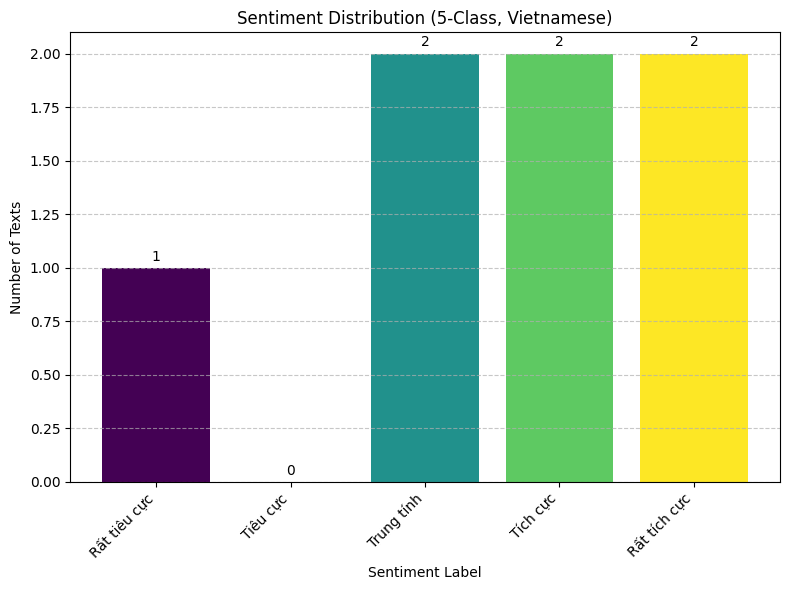

In [11]:
import matplotlib.pyplot as plt
import numpy as np # Often used with matplotlib, though not strictly necessary for this basic plot

# It's assumed that `analyse_sentiment_notebook` and `example_texts_vi` are defined 
# and available from previous cells.
# `counts_3_class` is also assumed to be available from the execution of the previous cell (cell 9).

def plot_sentiment_distribution_notebook(sentiment_counts, title_suffix=""):
    """
    Plots the distribution of sentiment counts as a bar chart in the notebook.

    Parameters:
    sentiment_counts (dict): A dictionary where keys are sentiment labels 
                             and values are the counts for each sentiment.
    title_suffix (str): A string to append to the plot title for context 
                        (e.g., "(3-Class, Vietnamese)").
    """
    if not sentiment_counts or not any(sentiment_counts.values()):
        print(f"No sentiment data to plot for {title_suffix.strip()}.")
        # Optionally, display an empty plot or a message on the plot
        # plt.figure(figsize=(8, 6))
        # plt.text(0.5, 0.5, "No data to display", ha='center', va='center', fontsize=12)
        # plt.title(f"Sentiment Distribution {title_suffix}")
        # plt.xticks([])
        # plt.yticks([])
        # plt.show()
        return

    labels = list(sentiment_counts.keys())
    counts = list(sentiment_counts.values())

    # Define a basic color palette using a Matplotlib colormap
    # Adjust 'viridis' to any other colormap like 'plasma', 'cividis', etc.
    # or provide a list of specific colors if preferred.
    num_labels = len(labels)
    colors = plt.cm.get_cmap('viridis', num_labels) 

    plt.figure(figsize=(max(8, 1.5 * num_labels), 6)) # Adjust width based on number of labels
    bars = plt.bar(labels, counts, color=[colors(i) for i in range(num_labels)])
    
    plt.xlabel("Sentiment Label")
    plt.ylabel("Number of Texts")
    plt.title(f"Sentiment Distribution {title_suffix}")
    
    # Add counts on top of bars
    max_count_val = max(counts) if counts else 1 
    for bar in bars:
        yval = bar.get_height()
        # Adjust offset for text based on the scale of y-values
        offset = max_count_val * 0.01 if max_count_val > 0 else 0.1 
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + offset, f'{int(yval)}', ha='center', va='bottom')

    plt.xticks(rotation=45, ha="right") # Rotate labels for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a light grid for the y-axis
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

# Plotting the 3-class results (using counts_3_class from the previous cell)
# Ensure the previous cell (cell 9) has been run to generate counts_3_class
if 'counts_3_class' in locals() or 'counts_3_class' in globals():
    print("\n--- Plotting 3-Class Sentiment Distribution (Vietnamese) ---")
    plot_sentiment_distribution_notebook(counts_3_class, title_suffix="(3-Class, Vietnamese)")
else:
    print("Warning: `counts_3_class` not found. Please run the previous cell (cell 9) first.")

# --- Running 5-Class Sentiment Analysis (Vietnamese) and Plotting ---
# This demonstrates how to use the plotting function for 5-class results.
print("\n\n--- Running 5-Class Sentiment Analysis (Vietnamese) ---")
# Assuming `analyse_sentiment_notebook` and `example_texts_vi` are available
sentiments_5_class, counts_5_class = analyse_sentiment_notebook(
    example_texts_vi, 
    language_code='vi', 
    num_classes=5  # Changed to 5 classes
)

# Print the 5-class results (optional, for verification)
print("\nSentiment Analysis Results (5-Class):")
for review, label, score in sentiments_5_class:
    print(f"Review: {review[:70]}...\nSentiment: {label} (Score: {score})\n---") # Truncate long reviews for printing
print("\nSentiment Counts (5-Class):")
for label, count in counts_5_class.items():
    print(f"{label}: {count}")

# Plotting the 5-class results
print("\n--- Plotting 5-Class Sentiment Distribution (Vietnamese) ---")
plot_sentiment_distribution_notebook(counts_5_class, title_suffix="(5-Class, Vietnamese)")


In [12]:
def simplified_absa_notebook(text, aspects, language_code='vi'):
    """
    Performs simplified Aspect-Based Sentiment Analysis.
    Finds sentences containing each aspect and runs 3-class sentiment analysis on them.
    Args:
        text (str): The input text to analyze.
        aspects (list of str): A list of aspect terms to search for.
        language_code (str): Language of the text.
    Returns:
        dict: A dictionary where keys are aspects and values are their determined sentiment labels.
    """
    # Ensure nltk.sent_tokenize has the necessary data
    try:
        sentences = sent_tokenize(text) # NLTK's sentence tokenizer
    except LookupError:
        nltk.download('punkt')
        sentences = sent_tokenize(text)
        
    aspect_sentiments = {}

    for aspect in aspects:
        relevant_sentences_sentiments = []
        for sentence in sentences:
            #print(aspect, sentence)
            if aspect.lower() in sentence.lower(): # Case-insensitive aspect search
                # Analyze the single sentence containing the aspect
                # We get a list of sentiments (with one item) and counts
                sentence_sentiment_list, _ = analyse_sentiment_notebook(
                    sentence, 
                    language_code=language_code, 
                    num_classes=3
                )
                if sentence_sentiment_list:
                    # The list contains (original_sentence, label, score)
                    relevant_sentences_sentiments.append(sentence_sentiment_list[0][1]) # Get the label

        if relevant_sentences_sentiments:
            # Simple aggregation: take the most common sentiment for the aspect
            # More sophisticated aggregation could be used (e.g., averaging scores if available for 3-class)
            # For this demo, Counter helps find the most common label.
            from collections import Counter
            sentiment_counts_for_aspect = Counter(relevant_sentences_sentiments)
            most_common_sentiment = sentiment_counts_for_aspect.most_common(1)[0][0]
            aspect_sentiments[aspect] = most_common_sentiment
        else:
            aspect_sentiments[aspect] = "Không tìm thấy khía cạnh (Aspect not found)"
            
    return aspect_sentiments

print("Simplified ABSA function loaded.")

Simplified ABSA function loaded.


In [13]:
print("\n--- Running Simplified Aspect-Based Sentiment Analysis (Vietnamese) ---")

absa_example_text_vi = "Món phở ở đây nước dùng rất đậm đà và thịt bò mềm. Tuy nhiên, không gian quán hơi chật chội."
# (Translation: "The pho here has a very rich broth and tender beef. However, the restaurant space is a bit cramped.")

aspects_to_analyze_vi = ["nước dùng", "thịt bò", "không gian quán"]
# (Aspects: "broth", "beef", "restaurant space")

absa_results_vi = simplified_absa_notebook(absa_example_text_vi, aspects_to_analyze_vi, language_code='vi')

print(f"\nAnalyzing text: \"{absa_example_text_vi}\"")
print("Aspect Sentiments:")
for aspect, sentiment in absa_results_vi.items():
    print(f"- {aspect}: {sentiment}")

print("\n--- Another ABSA Example ---")
absa_example_text_2_vi = "Bộ phim này có cốt truyện rất hay và diễn xuất của diễn viên chính thật tuyệt vời. Tuy nhiên, phần âm nhạc lại không mấy đặc sắc, khá là buồn ngủ."
aspects_to_analyze_2_vi = ["cốt truyện", "diễn xuất", "âm nhạc"]

absa_results_2_vi = simplified_absa_notebook(absa_example_text_2_vi, aspects_to_analyze_2_vi, language_code='vi')
print(f"\nAnalyzing text: \"{absa_example_text_2_vi}\"")
print("Aspect Sentiments:")
for aspect, sentiment in absa_results_2_vi.items():
    print(f"- {aspect}: {sentiment}")

# How to modify:
# 1. Change absa_example_text_vi to your target Vietnamese text.
# 2. Update aspects_to_analyze_vi with the list of aspects you're interested in for that text.


--- Running Simplified Aspect-Based Sentiment Analysis (Vietnamese) ---

Analyzing text: "Món phở ở đây nước dùng rất đậm đà và thịt bò mềm. Tuy nhiên, không gian quán hơi chật chội."
Aspect Sentiments:
- nước dùng: Tiêu cực
- thịt bò: Tiêu cực
- không gian quán: Trung tính

--- Another ABSA Example ---

Analyzing text: "Bộ phim này có cốt truyện rất hay và diễn xuất của diễn viên chính thật tuyệt vời. Tuy nhiên, phần âm nhạc lại không mấy đặc sắc, khá là buồn ngủ."
Aspect Sentiments:
- cốt truyện: Tích cực
- diễn xuất: Tích cực
- âm nhạc: Trung tính


In [14]:
print("\n--- Running Summarization (Vietnamese) ---")
summary_vi = run_summarizer_notebook(example_long_text_vi, chosen_ratio=0.3, lang='vi') # Adjust ratio as needed
print(f"Original Text Length: {len(example_long_text_vi.split())} words")
print(f"Summary (ratio 0.3):\n{summary_vi}")
print(f"Summary Length: {len(summary_vi.split())} words")

# How to modify:
# 1. Replace example_long_text_vi with your Vietnamese string.
# 2. Adjust chosen_ratio (0.1 to 1.0) to control summary length.
# 3. If reading from a file:
#    with open('your_vietnamese_text_file.txt', 'r', encoding='utf-8') as f:
#        my_text_content = f.read()
#    summary = run_summarizer_notebook(my_text_content, chosen_ratio=0.3, lang='vi')


--- Running Summarization (Vietnamese) ---
Error during summarization: Valid languages are: arabic, danish, dutch, english, finnish, french, german, hungarian, italian, norwegian, polish, portuguese, romanian, russian, spanish, swedish
Original Text Length: 207 words
Summary (ratio 0.3):
Hà Nội, thủ đô của Việt Nam, là một thành phố cổ kính với hơn một nghìn năm lịch sử.
Summary Length: 20 words
